In [47]:
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
import requests
from bs4 import BeautifulSoup
import re
import geopy # https://github.com/shakasom/geocoding/blob/master/geocoding.ipynb
from geopy.geocoders import Nominatim
import json
import geopy.distance
import numpy as np
import itertools
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import tabula
import datetime as dt
import missingno as msno
import seaborn as sns
import matplotlib as mpl

In [2]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [3]:
# Projected Coordinate System (PCS): how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System (GCS): how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Import historical apartment lease rates across Toronto from TRREB
- TRREB = Toronto Regional Real Estate Board
- aggregated level = MLB districts
- latest report: https://trreb.ca/index.php/market-news/rental-market-report

In [9]:
year= 2022
quarter = 4
r = requests.get(f"https://trreb.ca/files/market-stats/rental-reports/rental_report_Q{quarter}-{year}.pdf")

In [11]:
r.status_code == 404

True

In [12]:
# data before 2012 are in a different format
start_year = 2012
start_quarter = 1
year = start_year
quarter = start_quarter

while True:
    response = requests.get(f"https://trreb.ca/files/market-stats/rental-reports/rental_report_Q{quarter}-{year}.pdf")
    # if file is published, download it
    if response.status_code == 200:
        with open(f'../data/raw/rent/Q{quarter}-{year}.pdf', 'wb') as f:
            f.write(response.content)
        print(f"Downloaded Q{quarter}-{year}")
        if quarter == 4:
            year += 1
            quarter = 1
        else:
            quarter += 1    
    # if file is not published yet, stop
    else:
        break

end_year = year

Downloaded Q1-2012
Downloaded Q2-2012
Downloaded Q3-2012
Downloaded Q4-2012
Downloaded Q1-2013
Downloaded Q2-2013
Downloaded Q3-2013
Downloaded Q4-2013
Downloaded Q1-2014
Downloaded Q2-2014
Downloaded Q3-2014
Downloaded Q4-2014
Downloaded Q1-2015
Downloaded Q2-2015
Downloaded Q3-2015
Downloaded Q4-2015
Downloaded Q1-2016
Downloaded Q2-2016
Downloaded Q3-2016
Downloaded Q4-2016
Downloaded Q1-2017
Downloaded Q2-2017
Downloaded Q3-2017
Downloaded Q4-2017
Downloaded Q1-2018
Downloaded Q2-2018
Downloaded Q3-2018
Downloaded Q4-2018
Downloaded Q1-2019
Downloaded Q2-2019
Downloaded Q3-2019
Downloaded Q4-2019
Downloaded Q1-2020
Downloaded Q2-2020
Downloaded Q3-2020
Downloaded Q4-2020
Downloaded Q1-2021
Downloaded Q2-2021
Downloaded Q3-2021
Downloaded Q4-2021
Downloaded Q1-2022
Downloaded Q2-2022


In [23]:
years = [*range(start_year,end_year + 1,1)]
quarters = [*range(1,5,1)]
dfs = []
trreb_dfs = []
for year in years:
    for quarter in quarters:
        try:
            file1 = f'../data/raw/rent/Q{quarter}-{year}.pdf'
            # focus: apartment
            # we take the table on 3rd page = apartment rental transactions in City of Toronto
            # there are also tables on other pages, 
            # e.g. 5th page = townhouse rental transactions in City of Toronto
            table = tabula.read_pdf(file1, pages = '3', stream=True, area = (68.52,13.39,566.463,829.348))[0]
            table.drop(table.index[0:(np.where(table.iloc[:,0] == 'Toronto West')[0][0]-2)], inplace=True)
            table.dropna(axis=1, how='all', inplace=True)
            table.set_index(table.columns[0], inplace=True)
            splits = [table[col].str.split(pat=' ', expand=True).add_prefix(col) for col in table.columns]
            table = pd.concat(splits, axis=1)
            table = table.reset_index(drop=False)
            col1 = ['district'] + [x for x in ['AllApartments', 'Bachelor', 'OneBedroom', 'TwoBedroom', 'ThreeBedroom'] for _ in (0, 1)]
            col2 = ["", "Listed", "Leased"] + ["TotalLeased", "AvgLeaseRate"]*4
            table.columns = ['_'.join([x,y]).strip('_') for x, y in zip(col2,col1)]
            
            # save trreb total row
            trreb_table = table.iloc[0:1,:]
            trreb_table.iloc[:,1:] = trreb_table.iloc[:,1:].apply(lambda x_row: pd.Series([int(''.join(re.findall('\d+', x))) if re.findall('\d+', x) != [] else np.nan for x in x_row.values]), axis = 1).values
            trreb_table['Year'] = year
            trreb_table['Quarter'] = quarter
            trreb_table.replace(0, np.nan, inplace=True)
            trreb_dfs.append(trreb_table)
            
            table = table.loc[table['district'].apply(lambda x: re.search('\d+', x) is not None)]
            table['district'] = table['district'].apply(lambda x: re.search('\w\d{2}', x).group())
            table.iloc[:,1:] = table.iloc[:,1:].apply(lambda x_row: pd.Series([int(''.join(re.findall('\d+', x))) if re.findall('\d+', x) != [] else np.nan for x in x_row.values]), axis = 1).values
            table['Year'] = year
            table['Quarter'] = quarter
            table.replace(0, np.nan, inplace=True)
            table.reset_index(drop=True, inplace=True)
        except FileNotFoundError:
            table = None
        dfs.append(table)

C:\Users\willi\AppData\Local\Temp\ipykernel_28876\1549355676.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trreb_table.iloc[:,1:] = trreb_table.iloc[:,1:].apply(lambda x_row: pd.Series([int(''.join(re.findall('\d+', x))) if re.findall('\d+', x) != [] else np.nan for x in x_row.values]), axis = 1).values
C:\Users\willi\AppData\Local\Temp\ipykernel_28876\1549355676.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trreb_table['Year'] = year
C:\Users\willi\AppData\Local\Temp\ipykernel_28876\154935567

In [24]:
rent = pd.concat(dfs, axis=0)
rent

district  Listed_AllApartments  Leased_AllApartments  TotalLeased_Bachelor  \
0       W01                  66.0                  32.0                   NaN   
1       W02                  13.0                   9.0                   NaN   
2       W03                   3.0                   3.0                   NaN   
3       W04                  10.0                   2.0                   NaN   
4       W05                  43.0                  17.0                   NaN   
..      ...                   ...                   ...                   ...   
30      E07                 154.0                 115.0                   NaN   
31      E08                  46.0                  28.0                   1.0   
32      E09                 247.0                 198.0                   4.0   
33      E10                  16.0                   9.0                   NaN   
34      E11                  25.0                  20.0                   NaN   

    AvgLeaseRate_Bachelor  TotalLeased_OneBedroom  AvgLeaseRate_OneBedroom  \
0                     NaN                    24.0                   1539.0   
1                     NaN                     3.0                   1633.0   
2                     NaN                     2.0                   1050.0   
3                     NaN                     1.0                   1150.0   
4                     NaN                    12.0                   1354.0   
..                    ...                     ...                      ...   
30                    NaN                    64.0                   2005.0   
31                 1625.0                     4.0                   2200.0   
32                 1913.0                   110.0                   2140.0   
33                    NaN                     5.0                   1965.0   
34                    NaN                    10.0                   2010.0   

    TotalLeased_TwoBedroom  AvgLeaseRate_TwoBedroom  TotalLeased_ThreeBedroom  \
0                      8.0                   2031.0                       NaN   
1                      6.0                   1679.0                       NaN   
2                      1.0                   1650.0                       NaN   
3                      1.0                   1350.0                       NaN   
4                      5.0                   1578.0                       NaN   
..                     ...                      ...                       ...   
30                    49.0                   2506.0                       2.0   
31                    19.0                   2376.0                       4.0   
32                    72.0                   2710.0                      12.0   
33                     4.0                   2199.0                       NaN   
34                    10.0                   2445.0                       NaN   

    AvgLeaseRate_ThreeBedroom  Year  Quarter  
0                         NaN  2012        1  
1                         NaN  2012        1  
2                         NaN  2012        1  
3                         NaN  2012        1  
4                         NaN  2012        1  
..                        ...   ...      ...  
30                     2500.0  2022        2  
31                     2788.0  2022        2  
32                     3158.0  2022        2  
33                        NaN  2022        2  
34                        NaN  2022        2  

[1470 rows x 13 columns]

In [25]:
rent['YearQuarter'] = rent['Year'].astype(str) + 'Q' + rent['Quarter'].astype(str)

In [26]:
rent.sort_values(by=['district', 'YearQuarter'], inplace=True)

In [27]:
rent.reset_index(drop=True, inplace=True)

In [28]:
rent.describe()

Listed_AllApartments  Leased_AllApartments  TotalLeased_Bachelor  \
count           1463.000000           1449.000000            601.000000   
mean             332.314422            186.241546             19.803661   
std              927.951658            489.489679             48.709254   
min                1.000000              1.000000              1.000000   
25%               28.000000             14.000000              1.000000   
50%               71.000000             41.000000              3.000000   
75%              227.000000            127.000000              9.000000   
max            12795.000000           4968.000000            354.000000   

       AvgLeaseRate_Bachelor  TotalLeased_OneBedroom  AvgLeaseRate_OneBedroom  \
count             601.000000             1398.000000              1398.000000   
mean             1479.828619              115.008584              1756.250358   
std               253.265570              312.050980               325.633585   
min               175.000000                1.000000               850.000000   
25%              1321.000000                7.000000              1500.000000   
50%              1475.000000               22.000000              1771.000000   
75%              1660.000000               75.750000              1990.750000   
max              2758.000000             3101.000000              2878.000000   

       TotalLeased_TwoBedroom  AvgLeaseRate_TwoBedroom  \
count             1415.000000              1415.000000   
mean                64.429682              2334.085512   
std                143.692241               613.165326   
min                  1.000000              1075.000000   
25%                  7.000000              1900.000000   
50%                 18.000000              2283.000000   
75%                 53.000000              2662.500000   
max               1391.000000              5900.000000   

       TotalLeased_ThreeBedroom  AvgLeaseRate_ThreeBedroom         Year  \
count                980.000000                 980.000000  1470.000000   
mean                   6.134694                2964.223469  2016.761905   
std                   13.262580                1375.222225     3.038965   
min                    1.000000                 575.000000  2012.000000   
25%                    1.000000                2100.000000  2014.000000   
50%                    2.000000                2624.500000  2017.000000   
75%                    5.000000                3470.250000  2019.000000   
max                  169.000000               13925.000000  2022.000000   

           Quarter  
count  1470.000000  
mean      2.452381  
std       1.117400  
min       1.000000  
25%       1.000000  
50%       2.000000  
75%       3.000000  
max       4.000000

# Plot lease demand

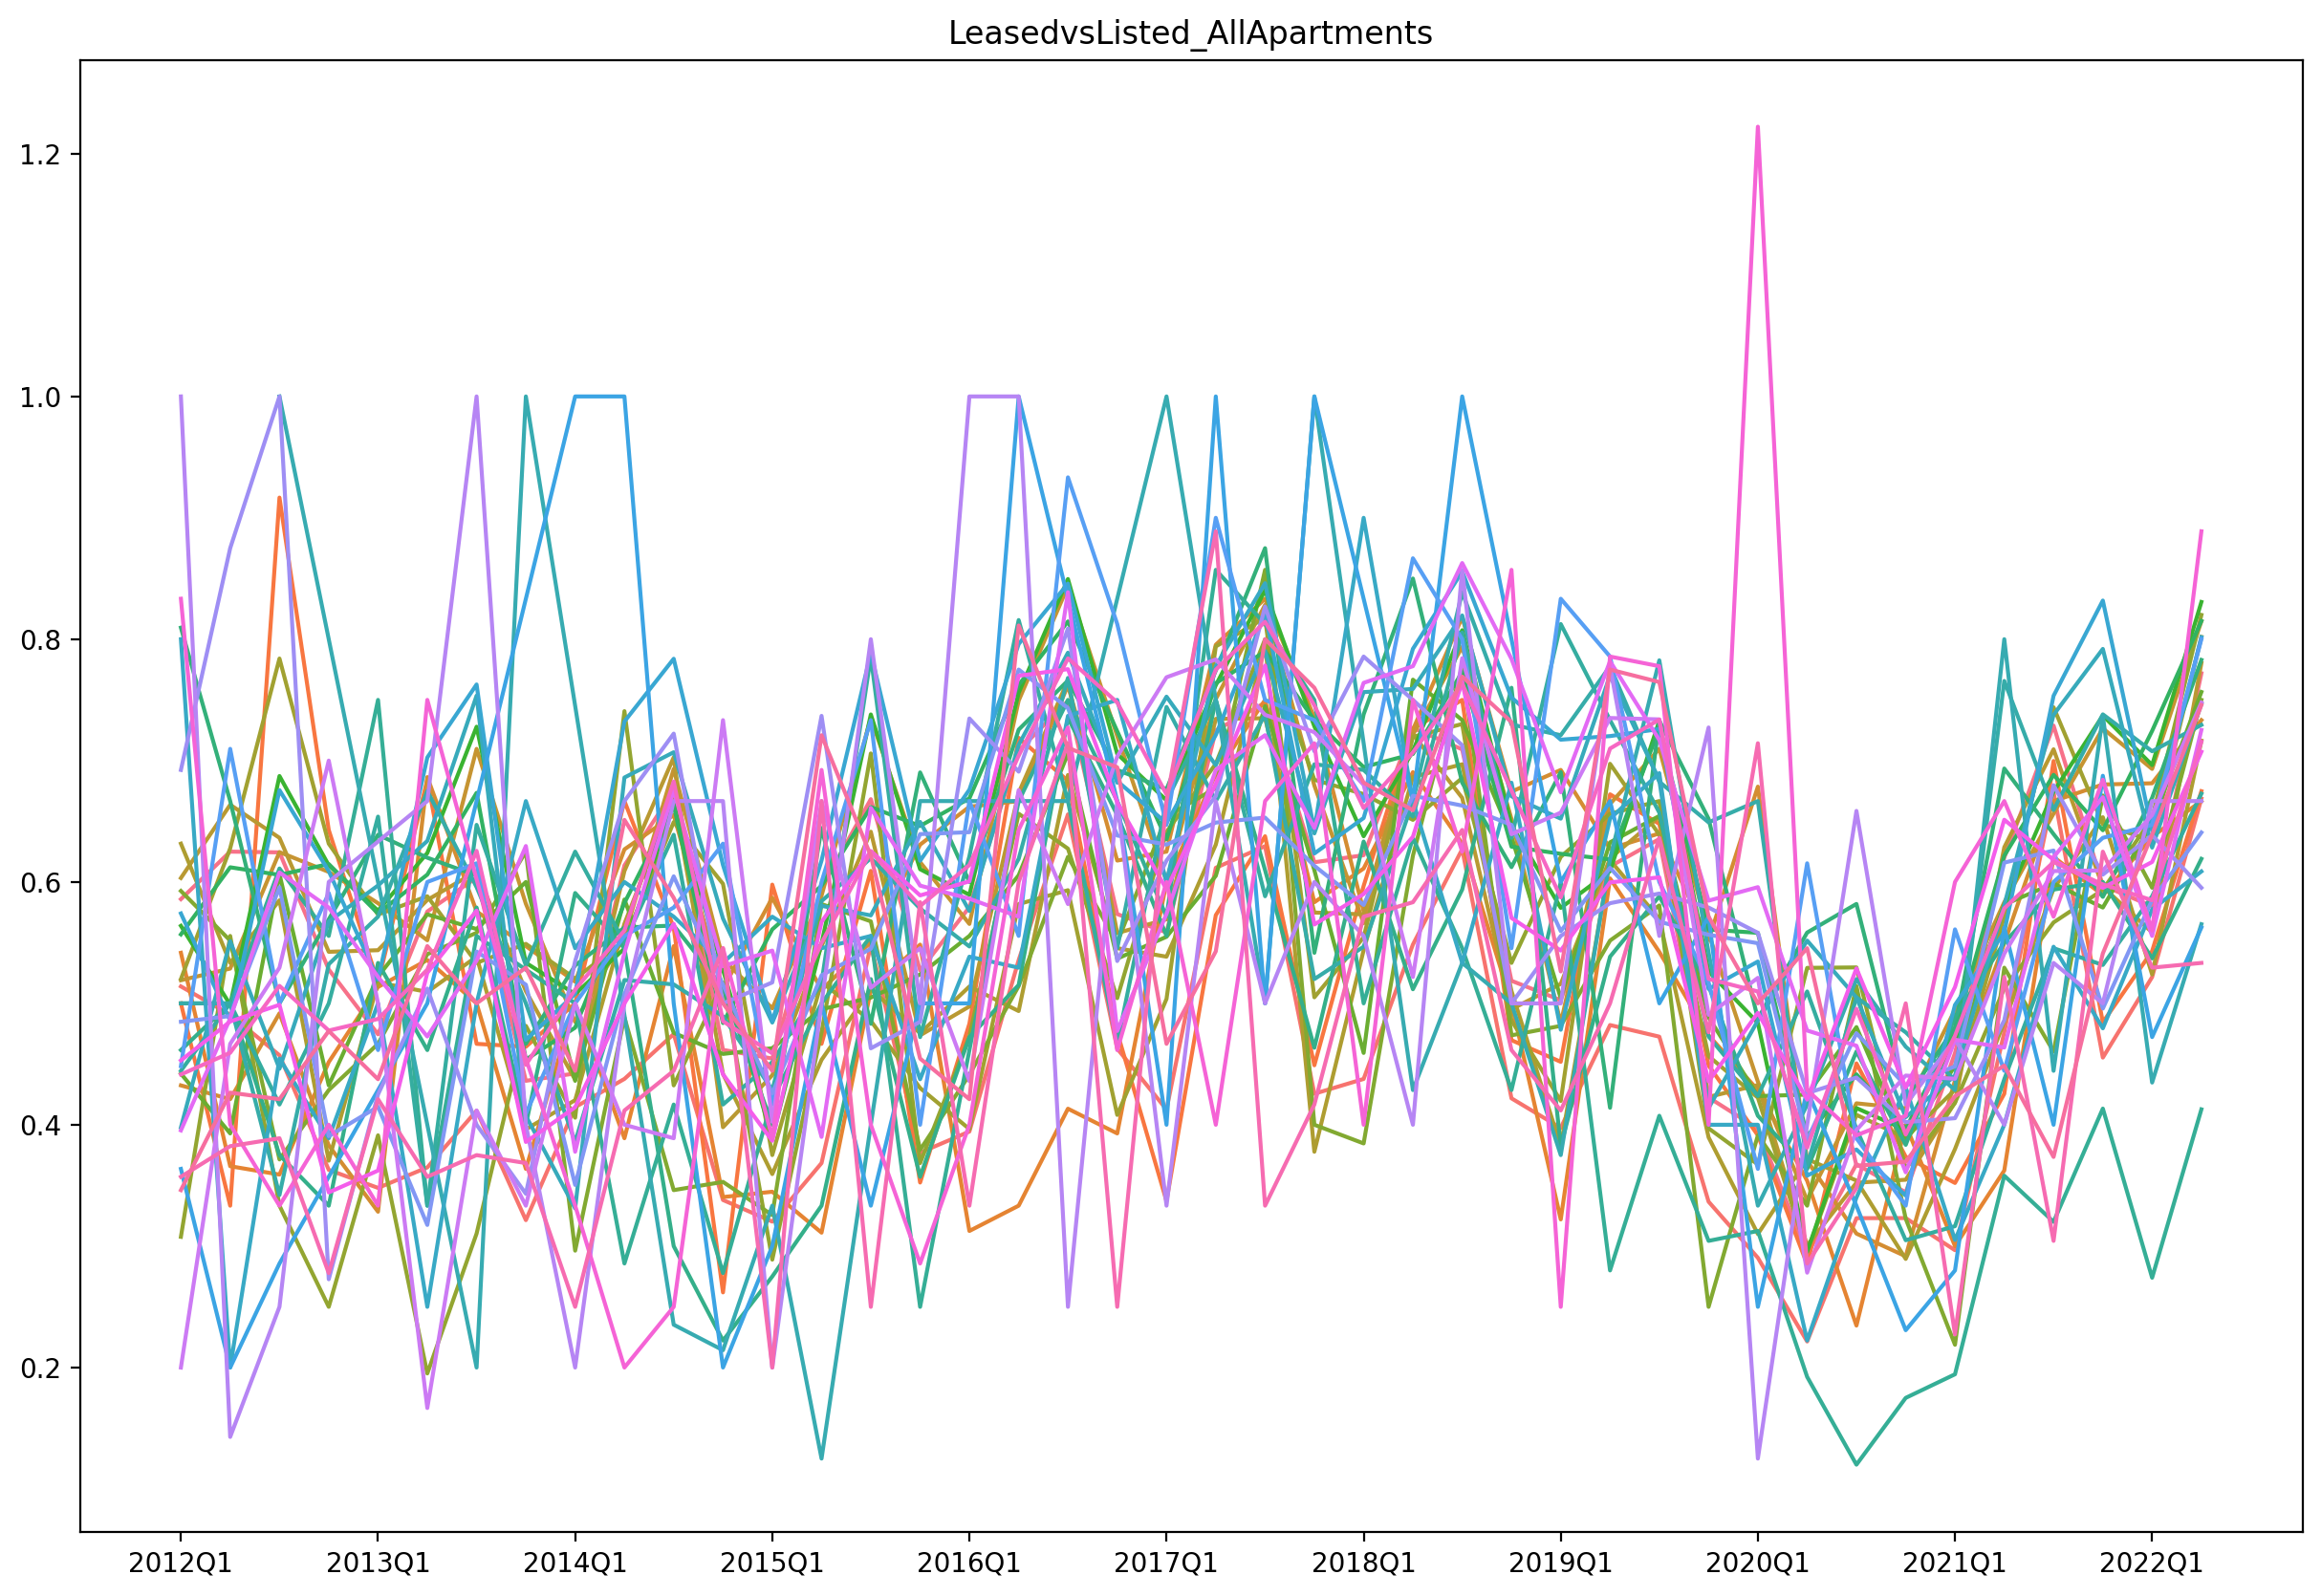

In [29]:
rent['LeasedvsListed_AllApartments'] = rent['Leased_AllApartments'] / rent['Listed_AllApartments']
ax = sns.lineplot(x='YearQuarter', y='LeasedvsListed_AllApartments', data=rent, hue='district', legend=False)
ax.title.set_text('LeasedvsListed_AllApartments')
ax.yaxis.label.set_visible(False)
ax.xaxis.label.set_visible(False)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(4))

In [30]:
# number of leased units / number of listing cannot be > 1
rent[['district', 'LeasedvsListed_AllApartments']].sort_values(by='LeasedvsListed_AllApartments', ascending=False).head(5)

district  LeasedvsListed_AllApartments
1334      W07                      1.222222
805       E06                      1.000000
818       E06                      1.000000
821       E06                      1.000000
1094      W02                      1.000000

In [31]:
# identify the problematic record 
location = np.where(rent['LeasedvsListed_AllApartments'] == rent['LeasedvsListed_AllApartments'].max())[0][0]
rent.loc[location:location,]

district  Listed_AllApartments  Leased_AllApartments  \
1334      W07                   9.0                  11.0   

      TotalLeased_Bachelor  AvgLeaseRate_Bachelor  TotalLeased_OneBedroom  \
1334                   NaN                    NaN                     5.0   

      AvgLeaseRate_OneBedroom  TotalLeased_TwoBedroom  \
1334                   2010.0                     6.0   

      AvgLeaseRate_TwoBedroom  TotalLeased_ThreeBedroom  \
1334                   2900.0                       NaN   

      AvgLeaseRate_ThreeBedroom  Year  Quarter YearQuarter  \
1334                        NaN  2020        1      2020Q1   

      LeasedvsListed_AllApartments  
1334                      1.222222

In [32]:
# fix the number of listing = number of leased
rent.loc[location:location, 'Listed_AllApartments'] = rent.loc[location:location, 'Leased_AllApartments']
rent.loc[location:location, 'LeasedvsListed_AllApartments'] = 1
rent.loc[location:location,]

district  Listed_AllApartments  Leased_AllApartments  \
1334      W07                  11.0                  11.0   

      TotalLeased_Bachelor  AvgLeaseRate_Bachelor  TotalLeased_OneBedroom  \
1334                   NaN                    NaN                     5.0   

      AvgLeaseRate_OneBedroom  TotalLeased_TwoBedroom  \
1334                   2010.0                     6.0   

      AvgLeaseRate_TwoBedroom  TotalLeased_ThreeBedroom  \
1334                   2900.0                       NaN   

      AvgLeaseRate_ThreeBedroom  Year  Quarter YearQuarter  \
1334                        NaN  2020        1      2020Q1   

      LeasedvsListed_AllApartments  
1334                           1.0

# Plot lease counts and rates

In [33]:
rent.columns

Index(['district', 'Listed_AllApartments', 'Leased_AllApartments',
       'TotalLeased_Bachelor', 'AvgLeaseRate_Bachelor',
       'TotalLeased_OneBedroom', 'AvgLeaseRate_OneBedroom',
       'TotalLeased_TwoBedroom', 'AvgLeaseRate_TwoBedroom',
       'TotalLeased_ThreeBedroom', 'AvgLeaseRate_ThreeBedroom', 'Year',
       'Quarter', 'YearQuarter', 'LeasedvsListed_AllApartments'],
      dtype='object')

In [34]:
lease_rates = [re.search('AvgLeaseRate_\w+', x).group(0) for x in rent.columns if re.search('AvgLeaseRate_\w+', x) is not None]
lease_count = [re.search('TotalLeased_\w+', x).group(0) for x in rent.columns if re.search('TotalLeased_\w+', x) is not None]

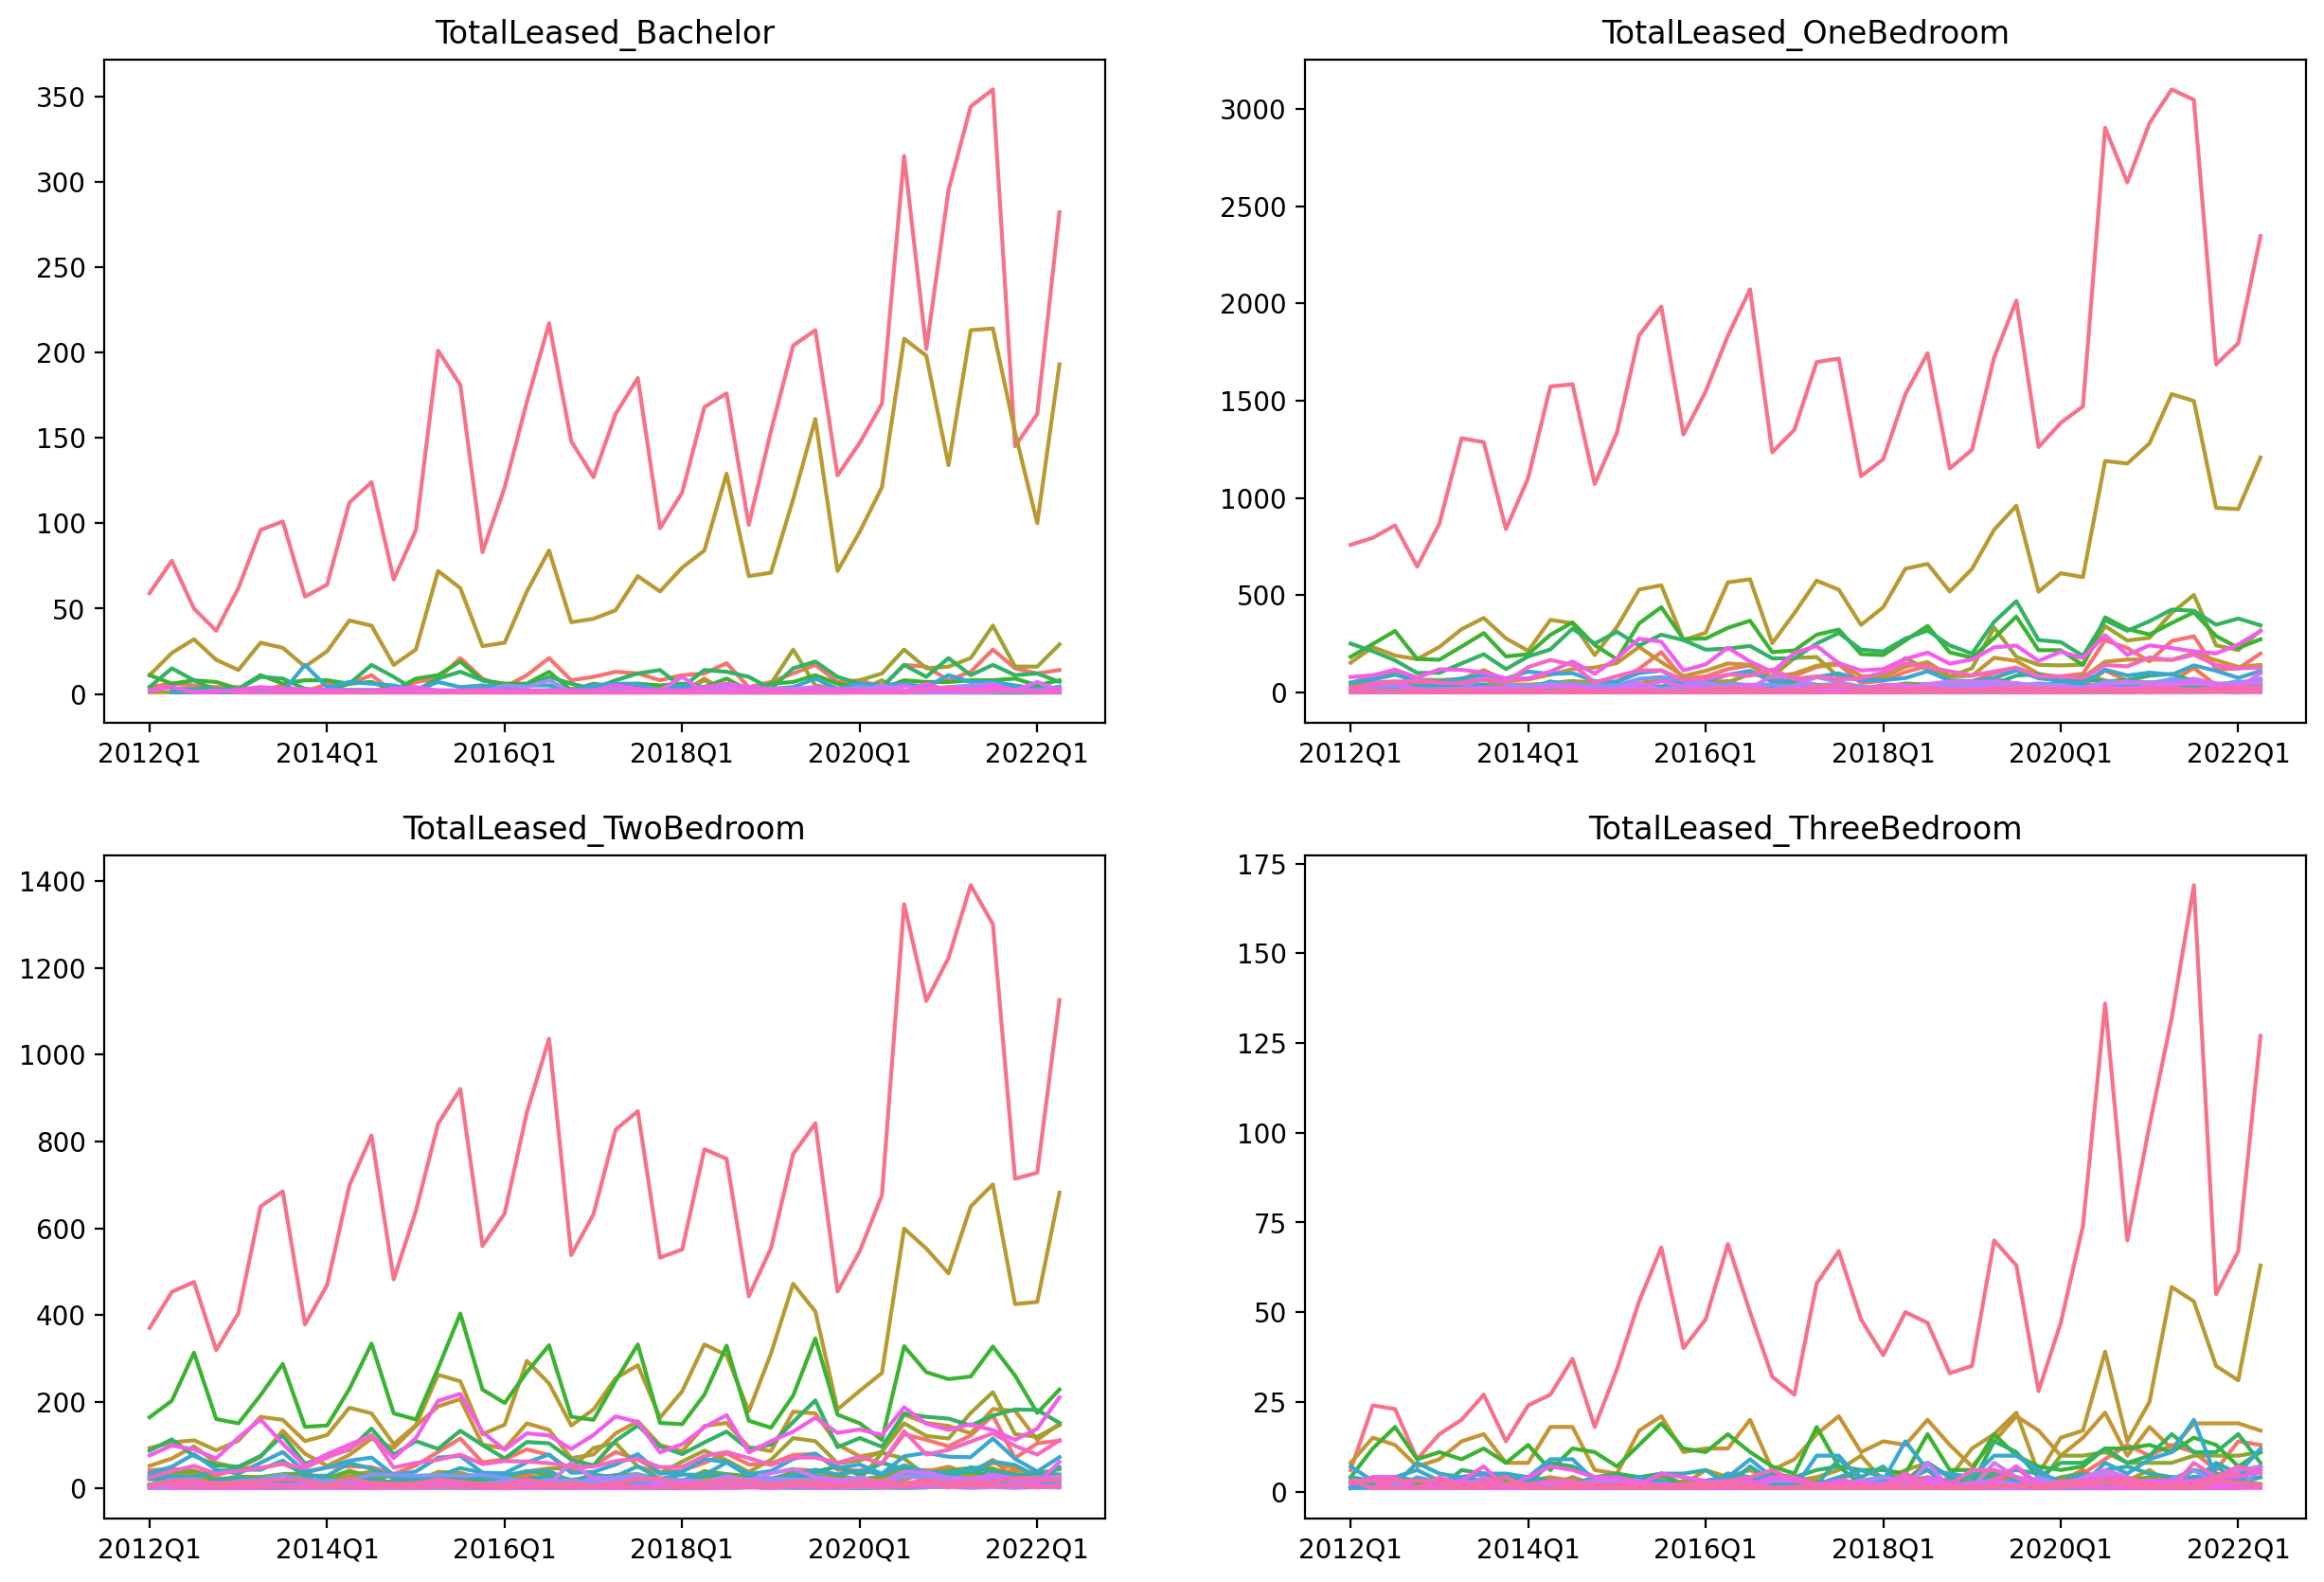

In [35]:
# plotting number of leased apartments by district
fig, axes = plt.subplots(int(len(lease_count)/2),2)
for col, ax in zip(lease_count, axes.flatten()):
    sns.lineplot(x='YearQuarter', y=col, data=rent, hue='district', legend=False, ax=ax)
    ax.title.set_text(col)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(8))

In [39]:
# As expexted, C08 and C01 are the districts closest to downtown
print(f"Top 5 districts by number of leased apartments as of {rent['YearQuarter'].max()}:")
rent[rent['YearQuarter'] == rent['YearQuarter'].max()].groupby('district').TotalLeased_Bachelor.mean().sort_values(ascending=False).head()

Top 5 districts by number of leased apartments as of 2022Q2:


district
C01    282.0
C08    193.0
C10     29.0
C02     14.0
C14      8.0
Name: TotalLeased_Bachelor, dtype: float64

Text(0.5, 0.98, 'Excluding C08 and C01')

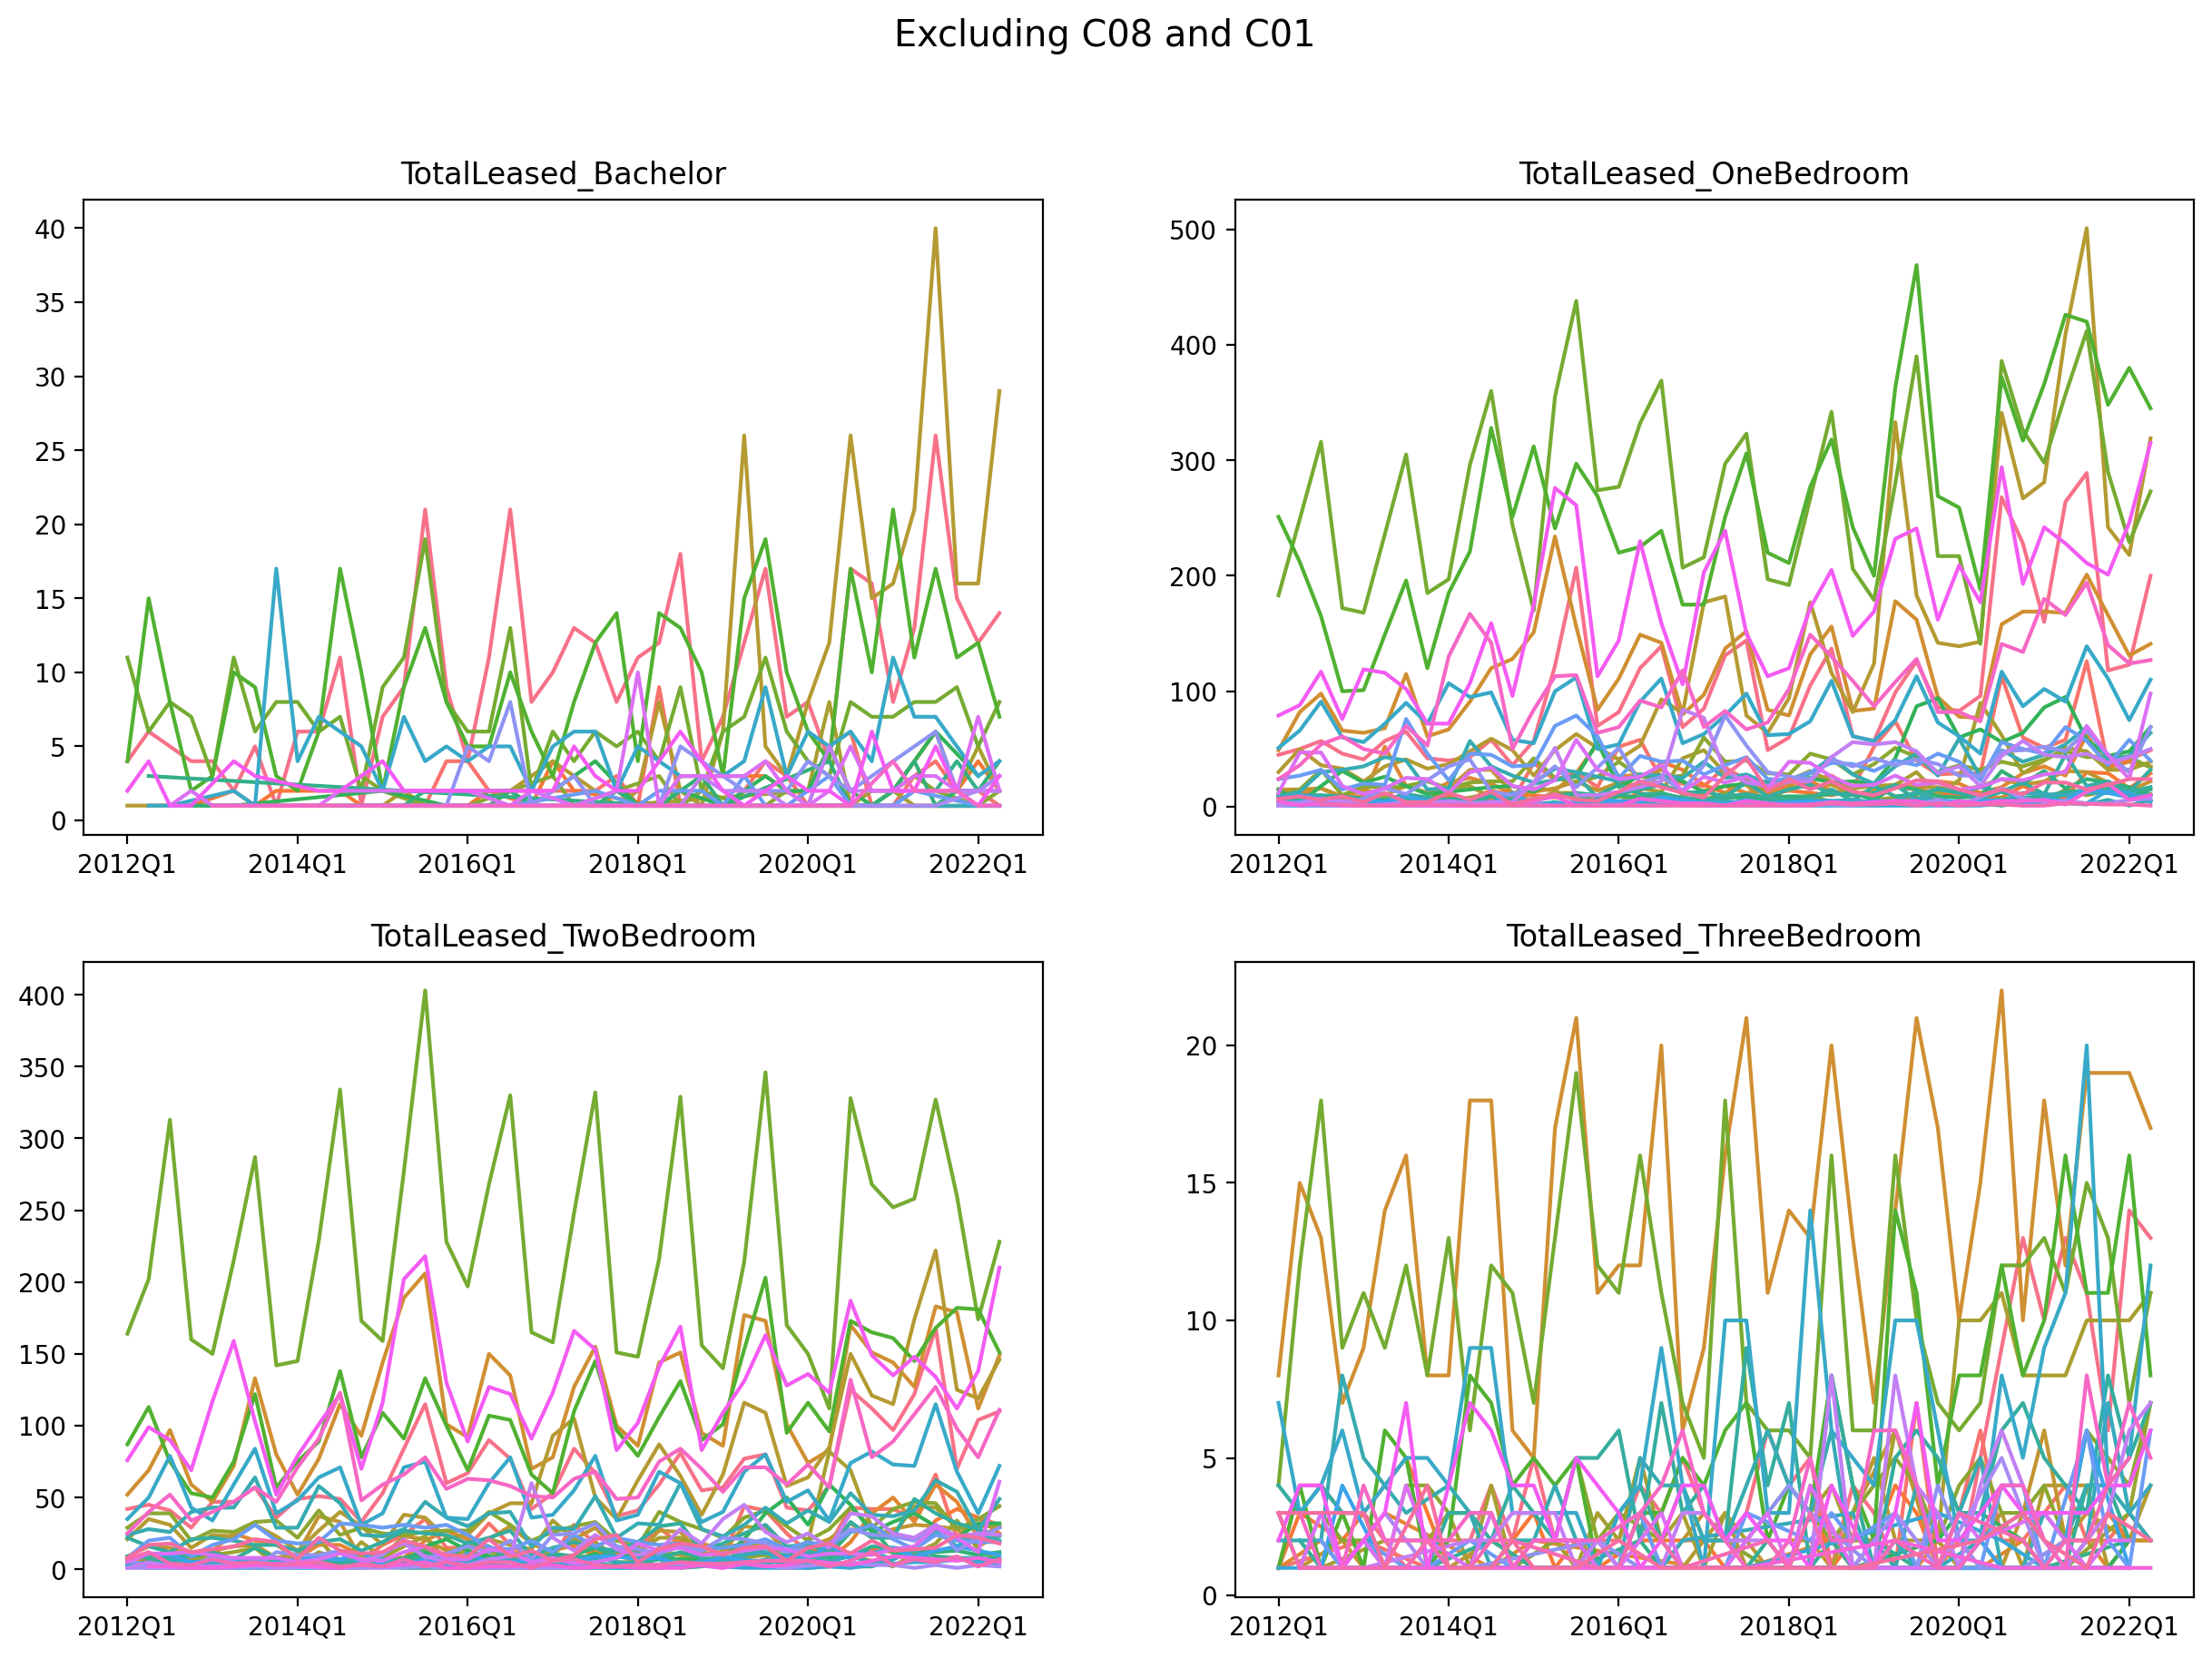

In [40]:
# Exclude the top 2 districts
fig, axes = plt.subplots(int(len(lease_count)/2),2)
for col, ax in zip(lease_count, axes.flatten()):
    sns.lineplot(x='YearQuarter', y=col, data=rent[~(rent['district'].isin(['C08', 'C01']))], hue='district', legend=False, ax=ax)
    ax.title.set_text(col)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(8))
fig.suptitle('Excluding C08 and C01', size = 'x-large')

# Fix average lease rate

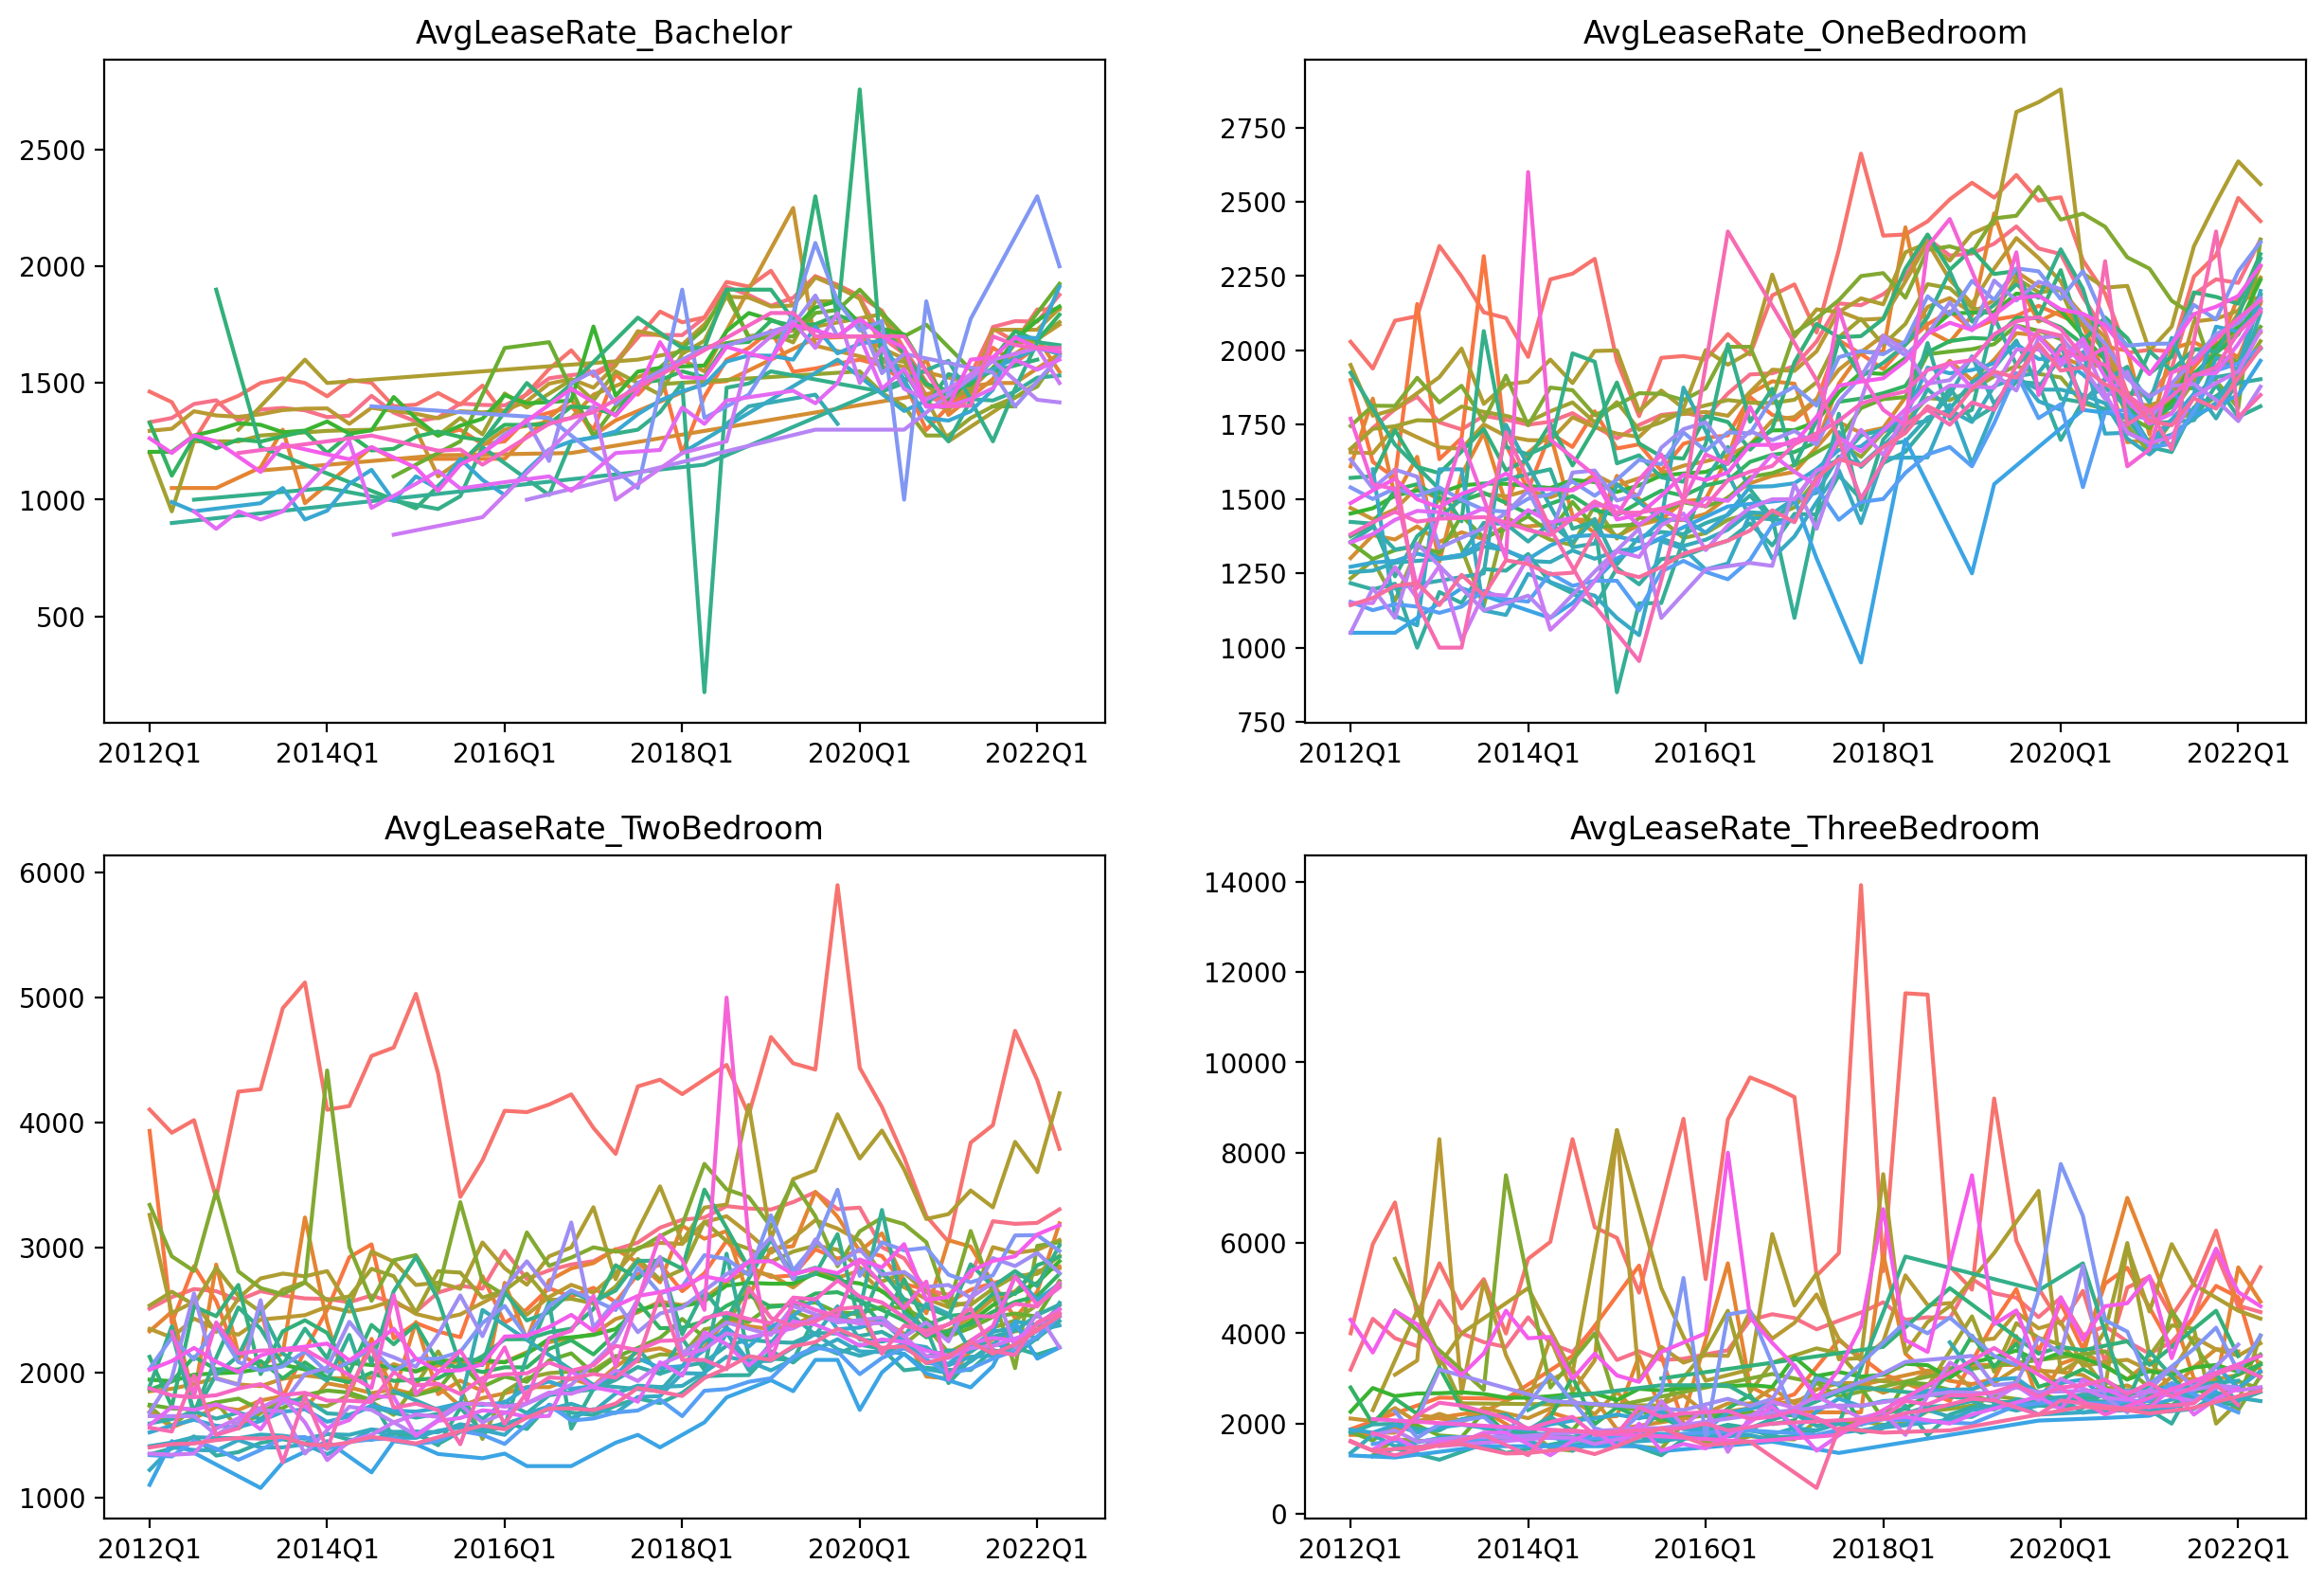

In [41]:
# plotting average lease rates of apartments by district
fig, axes = plt.subplots(int(len(lease_rates)/2),2)
for col, ax in zip(lease_rates, axes.flatten()):
    sns.lineplot(x='YearQuarter', y=col, data=rent, hue='district', legend=False, ax=ax)
    ax.title.set_text(col)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(8))

In [43]:
# the most expensive district for two bedroom is C02
rent[rent['AvgLeaseRate_TwoBedroom'] == rent['AvgLeaseRate_TwoBedroom'].max()]

district  Listed_AllApartments  Leased_AllApartments  TotalLeased_Bachelor  \
73      C02                 407.0                 137.0                   7.0   

    AvgLeaseRate_Bachelor  TotalLeased_OneBedroom  AvgLeaseRate_OneBedroom  \
73                 1921.0                    86.0                   2504.0   

    TotalLeased_TwoBedroom  AvgLeaseRate_TwoBedroom  TotalLeased_ThreeBedroom  \
73                    43.0                   5900.0                       1.0   

    AvgLeaseRate_ThreeBedroom  Year  Quarter YearQuarter  \
73                     5000.0  2019        4      2019Q4   

    LeasedvsListed_AllApartments  
73                      0.336609

In [44]:
# the suddent dip in 2018 in lease rate of bachelor apartments may not make sense
location = np.where(rent['AvgLeaseRate_Bachelor'] == rent['AvgLeaseRate_Bachelor'].min())[0][0]
rent.loc[(location-1):(location+1),['district', 'AvgLeaseRate_Bachelor', 'YearQuarter']]

district  AvgLeaseRate_Bachelor YearQuarter
654      E02                 1500.0      2018Q1
655      E02                  175.0      2018Q2
656      E02                 1480.0      2018Q3

In [45]:
# $175 per month for a bachelor does not make sense
# could be manual error for missing a zero in input
# let's remove the weird data point
rent.loc[location, 'AvgLeaseRate_Bachelor'] = np.nan
rent.loc[(location-1):(location+1),['district', 'AvgLeaseRate_Bachelor', 'YearQuarter']]

district  AvgLeaseRate_Bachelor YearQuarter
654      E02                 1500.0      2018Q1
655      E02                    NaN      2018Q2
656      E02                 1480.0      2018Q3

# TRREB total stats

In [55]:
# TRREB total = aggregate statistics across all districts in TRREB
trreb_total = pd.concat(trreb_dfs, axis=0)
trreb_total.reset_index(drop=True, inplace=True)
trreb_total['YearQuarter'] = trreb_total['Year'].astype(str) + 'Q' + trreb_total['Quarter'].astype(str)
trreb_total.sort_values(by=['YearQuarter'], inplace=True)
trreb_total['district'] = 'TRREB total'
trreb_total

district  Listed_AllApartments  Leased_AllApartments  \
0   TRREB total                  7096                  3804   
1   TRREB total                  8893                  4771   
2   TRREB total                  8845                  5241   
3   TRREB total                  7161                  3648   
4   TRREB total                  8816                  4277   
..          ...                   ...                   ...   
37  TRREB total                 24789                 14920   
38  TRREB total                 23522                 16121   
39  TRREB total                 16972                 10820   
40  TRREB total                 16475                 10110   
41  TRREB total                 17335                 13203   

    TotalLeased_Bachelor  AvgLeaseRate_Bachelor  TotalLeased_OneBedroom  \
0                     96                   1306                    2111   
1                    143                   1285                    2552   
2                    119                   1336                    2733   
3                     81                   1359                    1982   
4                     97                   1308                    2380   
..                   ...                    ...                     ...   
37                   659                   1462                    8979   
38                   729                   1704                    9426   
39                   392                   1718                    6169   
40                   362                   1730                    5974   
41                   582                   1829                    7483   

    AvgLeaseRate_OneBedroom  TotalLeased_TwoBedroom  AvgLeaseRate_TwoBedroom  \
0                      1538                    1522                     2089   
1                      1556                    1950                     2088   
2                      1605                    2250                     2097   
3                      1626                    1486                     2088   
4                      1597                    1700                     2114   
..                      ...                     ...                      ...   
37                     1887                    4931                     2583   
38                     2060                    5518                     2773   
39                     2099                    3968                     2763   
40                     2145                    3489                     2867   
41                     2269                    4739                     2979   

    TotalLeased_ThreeBedroom  AvgLeaseRate_ThreeBedroom  Year  Quarter  \
0                         75                       2079  2012        1   
1                        126                       2625  2012        2   
2                        139                       2660  2012        3   
3                         99                       2327  2012        4   
4                        100                       2737  2013        1   
..                       ...                        ...   ...      ...   
37                       351                       3355  2021        2   
38                       448                       3639  2021        3   
39                       291                       3679  2021        4   
40                       285                       3560  2022        1   
41                       399                       3790  2022        2   

   YearQuarter  
0       2012Q1  
1       2012Q2  
2       2012Q3  
3       2012Q4  
4       2013Q1  
..         ...  
37      2021Q2  
38      2021Q3  
39      2021Q4  
40      2022Q1  
41      2022Q2  

[42 rows x 14 columns]

Text(0.5, 0.98, 'Average lease rates across all Toronto districts')

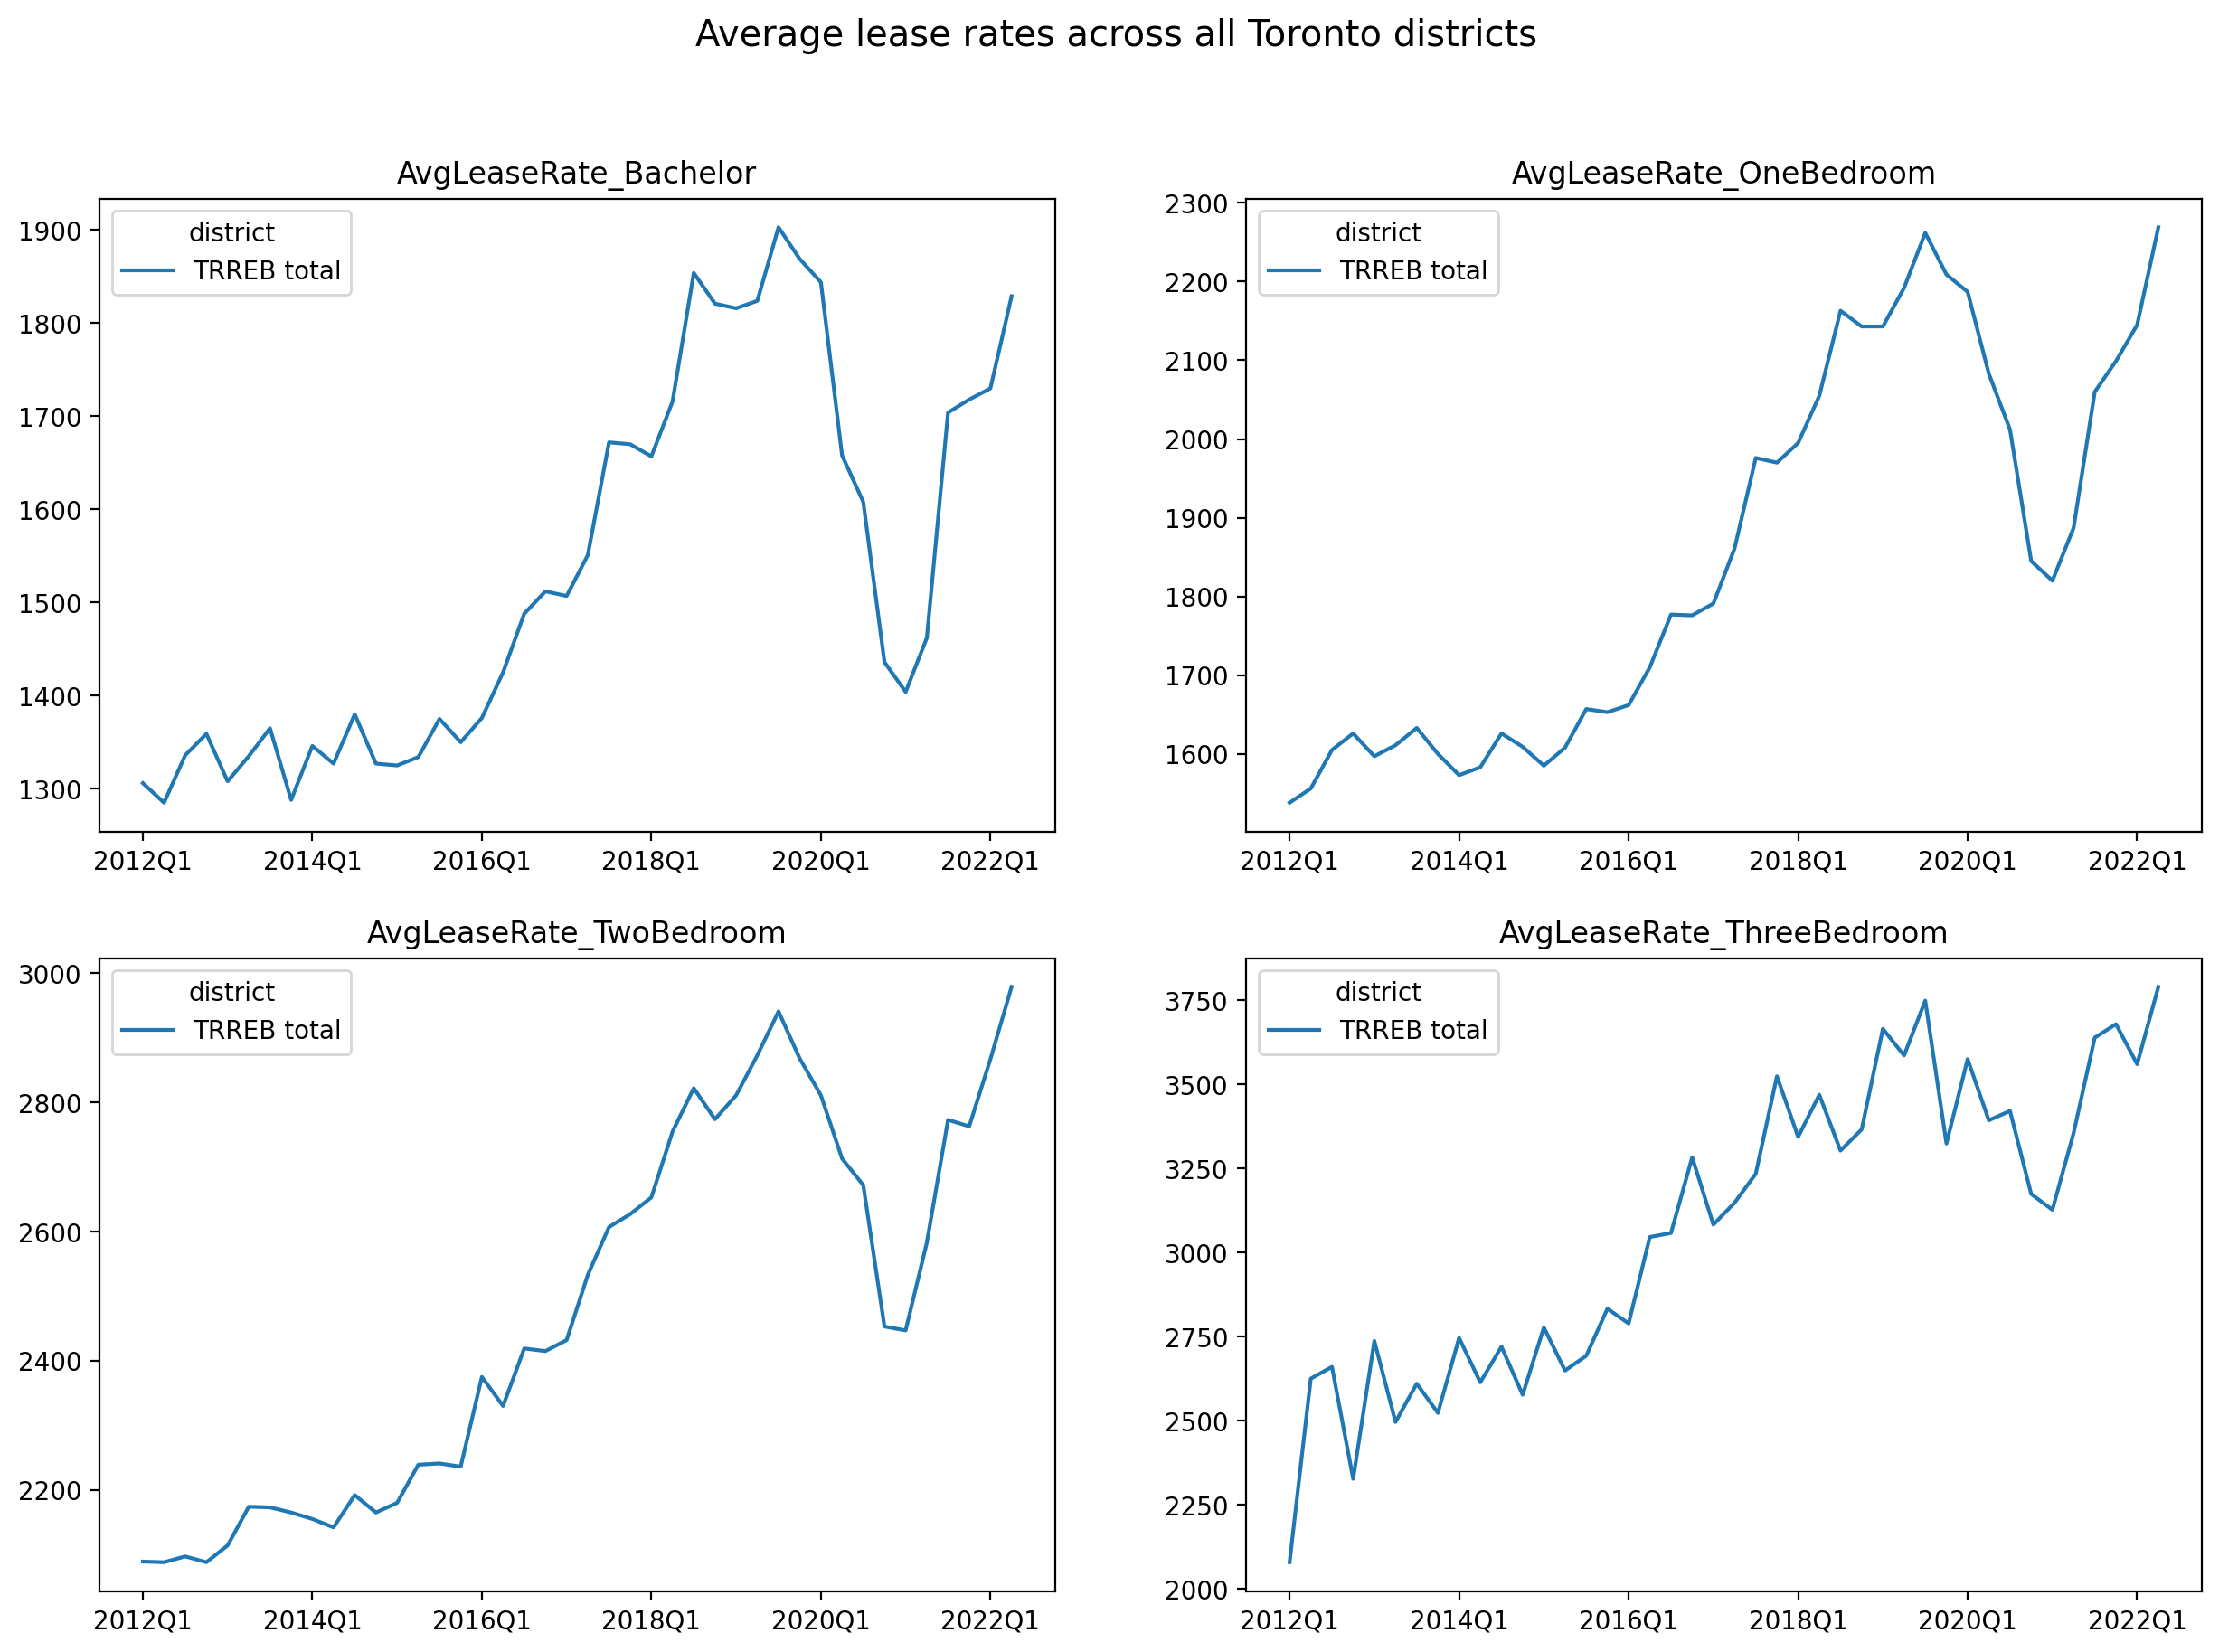

In [58]:
# plotting average lease rates of apartments across all districts
fig, axes = plt.subplots(int(len(lease_rates)/2),2)
for col, ax in zip(lease_rates, axes.flatten()):
    sns.lineplot(x='YearQuarter', y=col, data=trreb_total, hue='district', legend=True, ax=ax)
    ax.title.set_text(col)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(8))
fig.suptitle('Average lease rates across all Toronto districts', size = 'x-large')

# Check missing data

<AxesSubplot:>

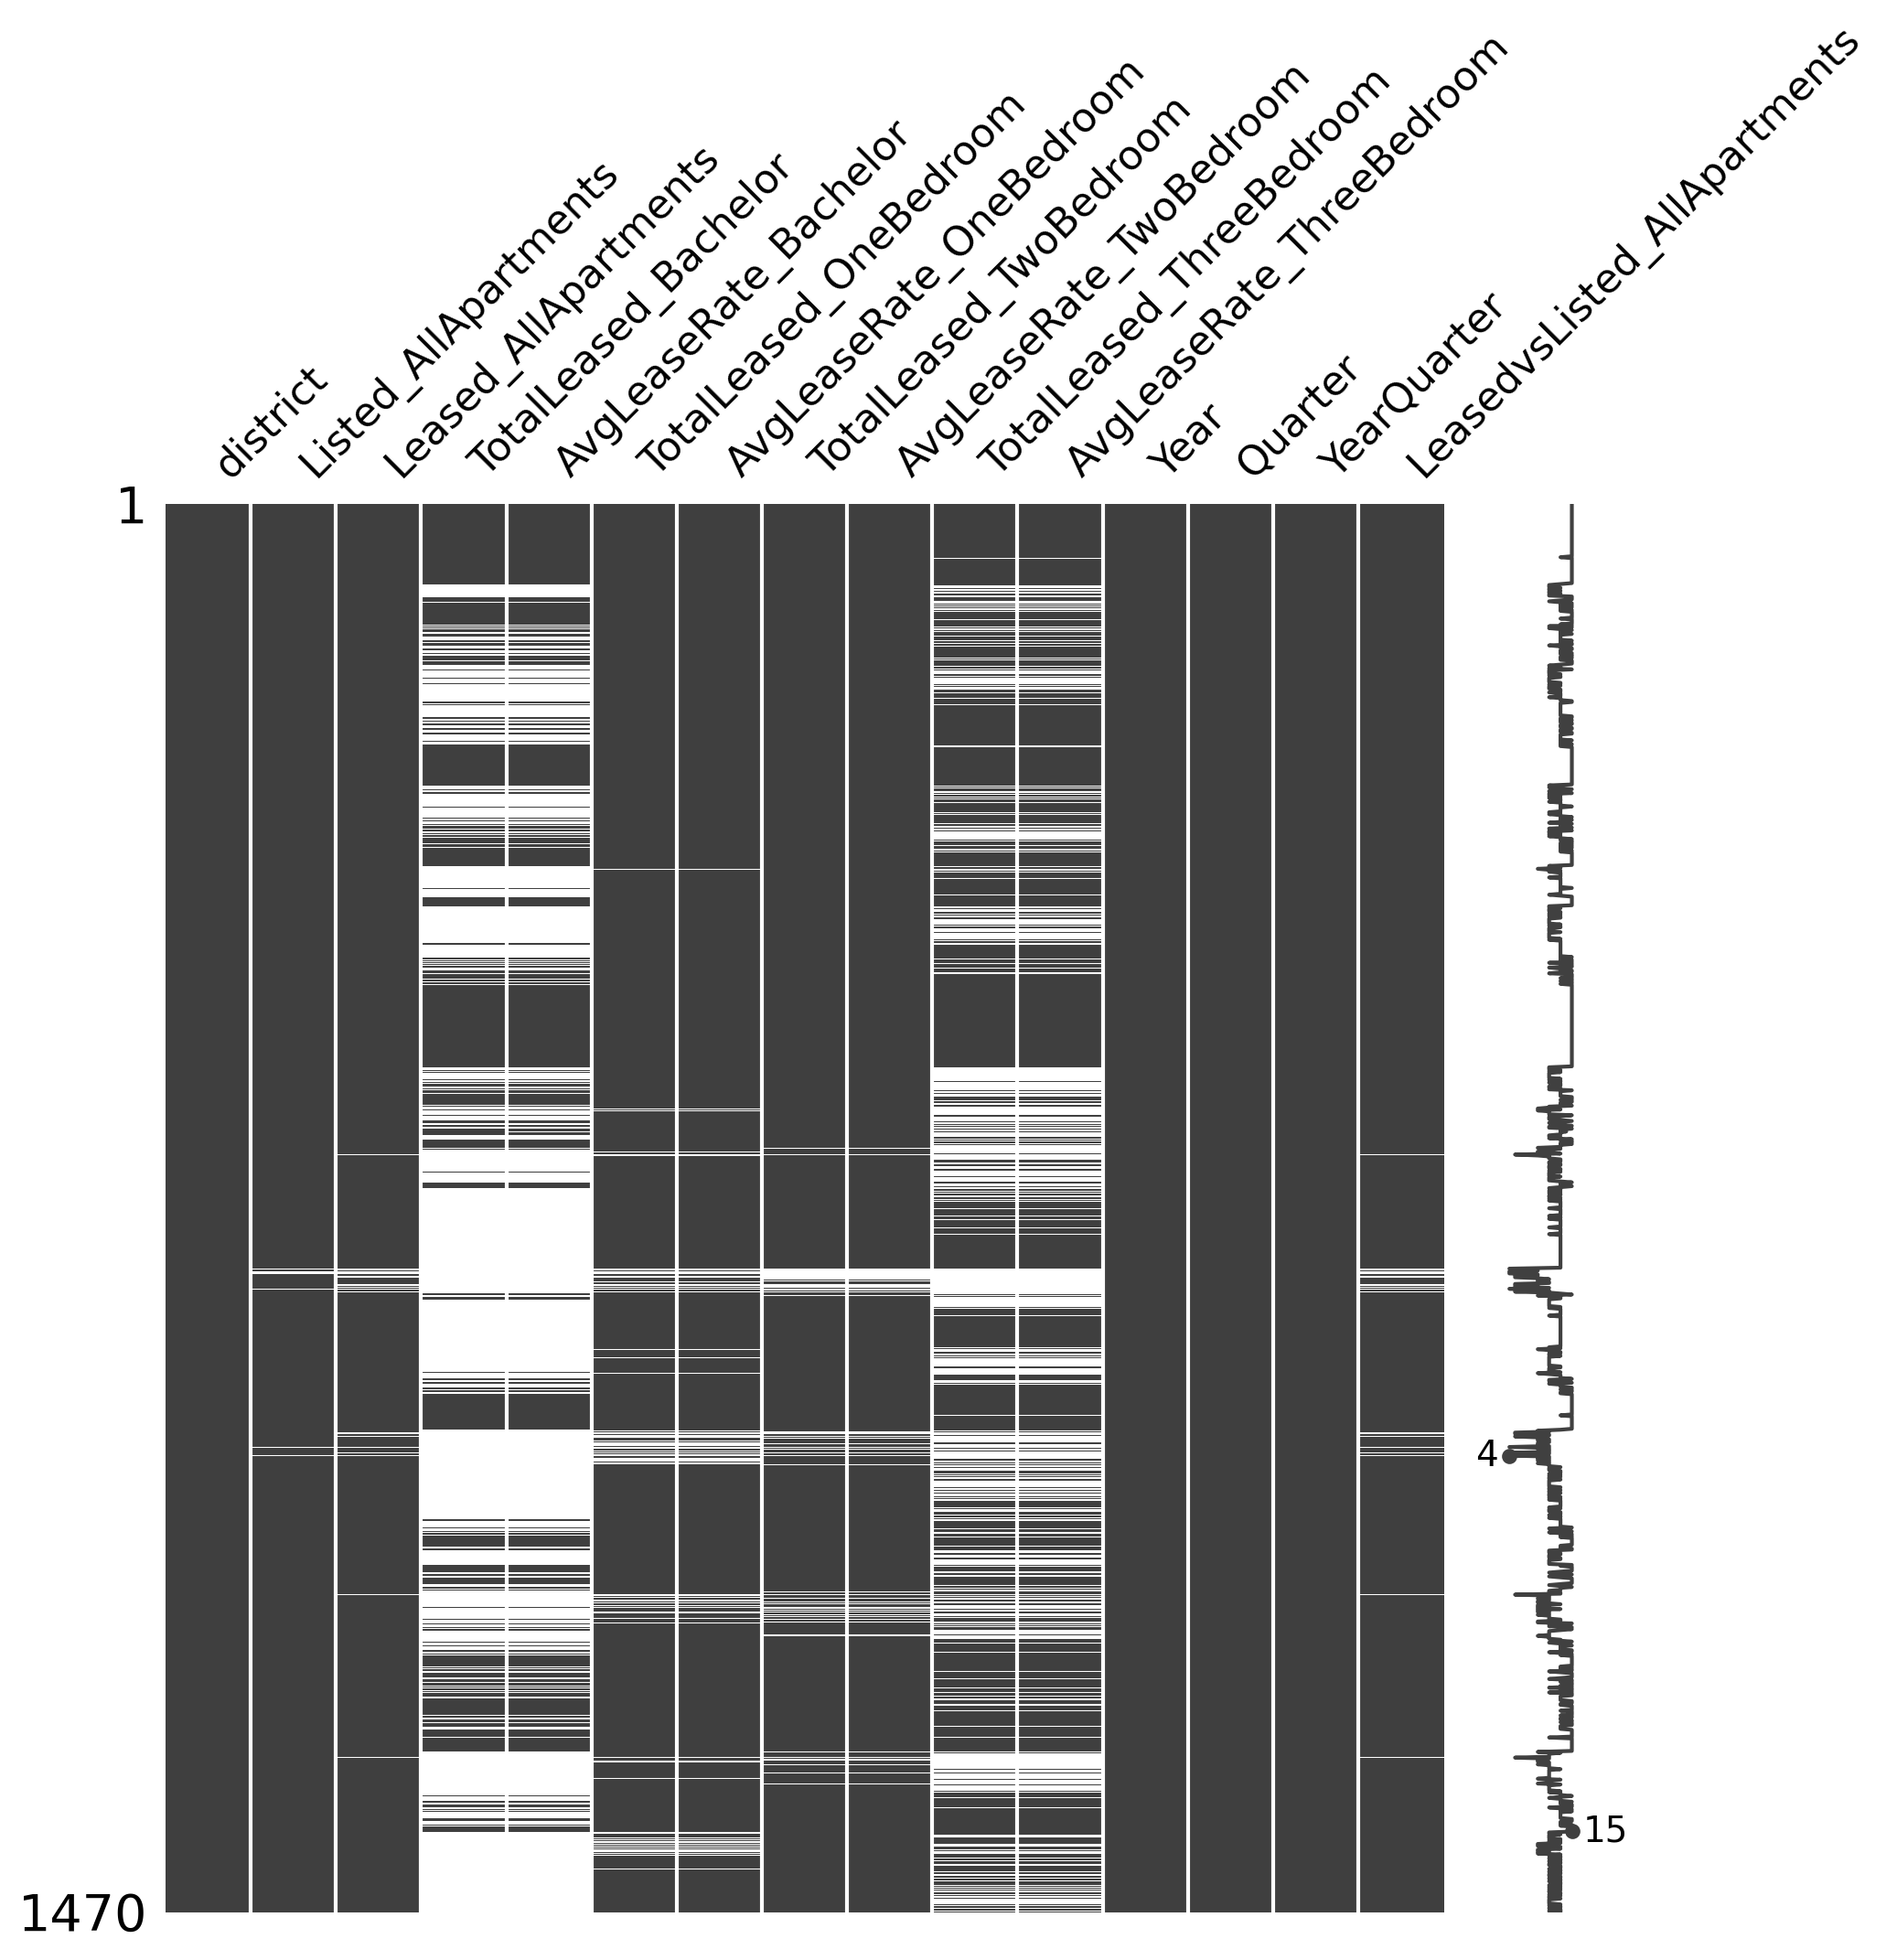

In [59]:
msno.matrix(rent, figsize=(10,10))

In [61]:
print("Percentage of missing data")
(rent.isna().sum(axis=0).sort_values(ascending=False) / rent.shape[0])*100

Percentage of missing data


AvgLeaseRate_Bachelor        59.183673
TotalLeased_Bachelor         59.115646
TotalLeased_ThreeBedroom     33.333333
AvgLeaseRate_ThreeBedroom    33.333333
TotalLeased_OneBedroom        4.897959
                               ...    
Listed_AllApartments          0.476190
district                      0.000000
Year                          0.000000
Quarter                       0.000000
YearQuarter                   0.000000
Length: 15, dtype: float64

# Drop bachelor apartments

In [62]:
# drop Bachelor apartments columns since over 50% of the data is missing
rent.drop(columns=['AvgLeaseRate_Bachelor', 'TotalLeased_Bachelor'], inplace=True)

# Interpolate NA values

In [63]:
# check rows with na
na_index = rent[rent.isna().sum(axis=1) != 0].head(1).index[0]
rent.iloc[(na_index - 1):(na_index + 2)]

district  Listed_AllApartments  Leased_AllApartments  \
55      C02                 589.0                 217.0   
56      C02                 626.0                 343.0   
57      C02                 374.0                 141.0   

    TotalLeased_OneBedroom  AvgLeaseRate_OneBedroom  TotalLeased_TwoBedroom  \
55                   122.0                   1779.0                    84.0   
56                   207.0                   1975.0                   115.0   
57                    70.0                   1981.0                    60.0   

    AvgLeaseRate_TwoBedroom  TotalLeased_ThreeBedroom  \
55                   4394.0                       2.0   
56                   3405.0                       NaN   
57                   3697.0                       2.0   

    AvgLeaseRate_ThreeBedroom  Year  Quarter YearQuarter  \
55                     4900.0  2015        2      2015Q2   
56                        NaN  2015        3      2015Q3   
57                     8750.0  2015        4      2015Q4   

    LeasedvsListed_AllApartments  
55                      0.368421  
56                      0.547923  
57                      0.377005

In [64]:
# missing data interpolated
pd.DataFrame(rent.iloc[(na_index - 1):(na_index + 2)]).interpolate(method='linear', axis=0)

district  Listed_AllApartments  Leased_AllApartments  \
55      C02                 589.0                 217.0   
56      C02                 626.0                 343.0   
57      C02                 374.0                 141.0   

    TotalLeased_OneBedroom  AvgLeaseRate_OneBedroom  TotalLeased_TwoBedroom  \
55                   122.0                   1779.0                    84.0   
56                   207.0                   1975.0                   115.0   
57                    70.0                   1981.0                    60.0   

    AvgLeaseRate_TwoBedroom  TotalLeased_ThreeBedroom  \
55                   4394.0                       2.0   
56                   3405.0                       2.0   
57                   3697.0                       2.0   

    AvgLeaseRate_ThreeBedroom  Year  Quarter YearQuarter  \
55                     4900.0  2015        2      2015Q2   
56                     6825.0  2015        3      2015Q3   
57                     8750.0  2015        4      2015Q4   

    LeasedvsListed_AllApartments  
55                      0.368421  
56                      0.547923  
57                      0.377005

In [65]:
# first interpolate within each neighbourhood only
# then assume the first record is NA, we do backward fill within each neighbourhood
for district in rent.district.unique():
    # rent.loc[rent['district'] == district] = rent.loc[rent['district'] == district].ffill(axis=0).bfill(axis=0).values
    rent.loc[rent['district'] == district] = rent.loc[rent['district'] == district].interpolate(method='linear', axis=0).bfill(axis=0).values

In [66]:
print("Percentage of missing data")
(rent.isna().sum(axis=0).sort_values(ascending=False) / rent.shape[0])*100

Percentage of missing data


district                        0.0
Listed_AllApartments            0.0
Leased_AllApartments            0.0
TotalLeased_OneBedroom          0.0
AvgLeaseRate_OneBedroom         0.0
                               ... 
AvgLeaseRate_ThreeBedroom       0.0
Year                            0.0
Quarter                         0.0
YearQuarter                     0.0
LeasedvsListed_AllApartments    0.0
Length: 13, dtype: float64

# Add per-bedroom statistics 

In [67]:
room_types = [re.search("TotalLeased_(\w+)", x).group(1) for x in rent.columns if re.search("TotalLeased_(\w+)", x) is not None]
room_types

['OneBedroom', 'TwoBedroom', 'ThreeBedroom']

In [68]:
# to compare number of leased aparatments and lease rates across different room types
# we must normalize by the number of rooms
for type in room_types:
    
    if type == 'OneBedroom':
        room_num = 1
    elif type == 'TwoBedroom':
        room_num = 2
    elif type == 'ThreeBedroom':
        room_num = 3
    
    # for number of leased apartments, we multiply by the number of bedrooms
    # e.g. 1 listing of 3-bedroom apartment = 3 listings of 1-bedroom apartment
    rent['TotalLeasedPerRoom_' + type] = rent['TotalLeased_' + type] * room_num
    
    # for number of leased apartments, we divide by the number of bedrooms
    # since you split the cost with your roommates
    rent['AvgLeaseRatePerRoom_' + type] = rent['AvgLeaseRate_' + type] / room_num

In [69]:
for agg_type in ['AllApartments', 'SharedApartments']:
    rent['TotalLeased_' + agg_type] = 0
    rent['TotalLeasedPerRoom_' + agg_type] = 0
    rent['AvgLeaseRate_' + agg_type] = 0
    rent['AvgLeaseRatePerRoom_' + agg_type] = 0
    if agg_type == 'AllApartments':
        room_list = room_types
    elif agg_type == 'SharedApartments':
        room_list = ['TwoBedroom', 'ThreeBedroom']
    for room in room_list:
        rent['TotalLeased_' + agg_type] += rent['TotalLeased_' + room]
        rent['AvgLeaseRate_' + agg_type] += rent['AvgLeaseRate_' + room] * rent['TotalLeased_' + room]
        rent['TotalLeasedPerRoom_' + agg_type] += rent['TotalLeasedPerRoom_' + room]
        rent['AvgLeaseRatePerRoom_' + agg_type] += rent['AvgLeaseRatePerRoom_' + room] * rent['TotalLeasedPerRoom_' + room]

    rent['AvgLeaseRate_' + agg_type] = rent['AvgLeaseRate_' + agg_type] / rent['TotalLeased_' + agg_type]
    rent['AvgLeaseRatePerRoom_' + agg_type] = rent['AvgLeaseRatePerRoom_' + agg_type] / rent['TotalLeasedPerRoom_' + agg_type]

In [70]:
rent

district  Listed_AllApartments  Leased_AllApartments  \
0         C01                2038.0                1194.0   
1         C01                2160.0                1350.0   
2         C01                2255.0                1408.0   
3         C01                1917.0                1012.0   
4         C01                2845.0                1350.0   
...       ...                   ...                   ...   
1465      W10                  78.0                  35.0   
1466      W10                  83.0                  31.0   
1467      W10                  85.0                  46.0   
1468      W10                  72.0                  46.0   
1469      W10                  59.0                  44.0   

      TotalLeased_OneBedroom  AvgLeaseRate_OneBedroom  TotalLeased_TwoBedroom  \
0                      759.0                   1666.0                   370.0   
1                      795.0                   1739.0                   453.0   
2                      859.0                   1802.0                   476.0   
3                      647.0                   1844.0                   319.0   
4                      868.0                   1758.0                   404.0   
...                      ...                      ...                     ...   
1465                    21.0                   1748.0                    14.0   
1466                    15.0                   1839.0                    15.0   
1467                    19.0                   1804.0                    24.0   
1468                    24.0                   1907.0                    22.0   
1469                    24.0                   2009.0                    18.0   

      AvgLeaseRate_TwoBedroom  TotalLeased_ThreeBedroom  \
0                      2510.0                       6.0   
1                      2603.0                      24.0   
2                      2667.0                      23.0   
3                      2650.0                       9.0   
4                      2578.0                      16.0   
...                       ...                       ...   
1465                   2243.0                       1.5   
1466                   2150.0                       1.0   
1467                   2223.0                       3.0   
1468                   2337.0                       2.5   
1469                   2453.0                       2.0   

      AvgLeaseRate_ThreeBedroom  Year  Quarter YearQuarter  \
0                        3194.0  2012        1      2012Q1   
1                        4321.0  2012        2      2012Q2   
2                        3891.0  2012        3      2012Q3   
3                        3717.0  2012        4      2012Q4   
4                        4719.0  2013        1      2013Q1   
...                         ...   ...      ...         ...   
1465                     2287.5  2021        2      2021Q2   
1466                     2350.0  2021        3      2021Q3   
1467                     2483.0  2021        4      2021Q4   
1468                     2604.0  2022        1      2022Q1   
1469                     2725.0  2022        2      2022Q2   

      LeasedvsListed_AllApartments  TotalLeasedPerRoom_OneBedroom  \
0                         0.585868                          759.0   
1                         0.625000                          795.0   
2                         0.624390                          859.0   
3                         0.527908                          647.0   
4                         0.474517                          868.0   
...                            ...                            ...   
1465                      0.448718                           21.0   
1466                      0.373494                           15.0   
1467                      0.541176                           19.0   
1468                      0.638889                           24.0   
1469                      0.745763                           24.0   

      AvgLeaseRa

# Output

In [71]:
# specify separator and suffix
rent_output = pd.wide_to_long(
    rent, 
    stubnames=['TotalLeased', 'AvgLeaseRate', 'TotalLeasedPerRoom', 'AvgLeaseRatePerRoom'], 
    i=['district', 'Listed_AllApartments', 'Leased_AllApartments', 'LeasedvsListed_AllApartments', 'Year', 'Quarter', 'YearQuarter'], 
    j='RoomType', 
    sep='_',
    suffix='\w+'
    ).reset_index()

In [72]:
rent_output

district  Listed_AllApartments  Leased_AllApartments  \
0         C01                2038.0                1194.0   
1         C01                2038.0                1194.0   
2         C01                2038.0                1194.0   
3         C01                2038.0                1194.0   
4         C01                2038.0                1194.0   
...       ...                   ...                   ...   
7345      W10                  59.0                  44.0   
7346      W10                  59.0                  44.0   
7347      W10                  59.0                  44.0   
7348      W10                  59.0                  44.0   
7349      W10                  59.0                  44.0   

      LeasedvsListed_AllApartments  Year  Quarter YearQuarter  \
0                         0.585868  2012        1      2012Q1   
1                         0.585868  2012        1      2012Q1   
2                         0.585868  2012        1      2012Q1   
3                         0.585868  2012        1      2012Q1   
4                         0.585868  2012        1      2012Q1   
...                            ...   ...      ...         ...   
7345                      0.745763  2022        2      2022Q2   
7346                      0.745763  2022        2      2022Q2   
7347                      0.745763  2022        2      2022Q2   
7348                      0.745763  2022        2      2022Q2   
7349                      0.745763  2022        2      2022Q2   

              RoomType  TotalLeased  AvgLeaseRate  TotalLeasedPerRoom  \
0           OneBedroom        759.0   1666.000000               759.0   
1           TwoBedroom        370.0   2510.000000               740.0   
2         ThreeBedroom          6.0   3194.000000                18.0   
3        AllApartments       1135.0   1949.214097              1517.0   
4     SharedApartments        376.0   2520.914894               758.0   
...                ...          ...           ...                 ...   
7345        OneBedroom         24.0   2009.000000                24.0   
7346        TwoBedroom         18.0   2453.000000                36.0   
7347      ThreeBedroom          2.0   2725.000000                 6.0   
7348     AllApartments         44.0   2223.181818                66.0   
7349  SharedApartments         20.0   2480.200000                42.0   

      AvgLeaseRatePerRoom  
0             1666.000000  
1             1255.000000  
2             1064.666667  
3             1458.377060  
4             1250.480211  
...                   ...  
7345          2009.000000  
7346          1226.500000  
7347           908.333333  
7348          1482.121212  
7349          1181.047619  

[7350 rows x 12 columns]

In [73]:
rent_output.to_csv('../data/processed/rent.csv', index=False)

In [74]:
trreb_total.to_csv('../data/processed/trreb_total.csv', index=False)

# Improvements
- granularity by postal code, or even by property (idiosyncratic differences do exist within the same neighbourhood)
- Reference for getting data from zumper: https://medium.com/@backupfairuz/exploring-rental-rates-in-canada-hands-on-project-making-use-of-foursquare-api-with-python-413793d2dfca

In [ ]:
# Improvement
# bungol.ca for data of housing transaction prices (not listing like other websites)
# real transaction data instead of listings
# access to paid APIs https://rapidapi.com/blog/best-real-estate-apis/